# Bankfull Depth - Model 02

## Import required libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from utils import Scatter_Violin_Plots, Performance_metrics, Hbar
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GroupShuffleSplit, GroupKFold
import pickle
from sklearn.inspection import permutation_importance

## Import dataset

In [2]:
# Import the training dataset
train = pd.read_csv('./DataPreProcessing/df_Train.csv', converters={'site_no': str}, low_memory=False)

# Import the testing dataset
test = pd.read_csv('./DataPreProcessing/df_Test.csv', converters={'site_no': str}, low_memory=False)

## Split dataset into train and test sets

In [4]:
# Spliting the dependent (y) variable and independent (X) variables for training dataset
y_train = train[['mean_depth_va_bnk']]
X_train = train[['QE_cms', 'TotDASqKM', 'CAT_EVI_OND_2011', 'CAT_EVI_AMJ_2012',
                 'CAT_EVI_JAS_2012', 'CAT_EVI_JFM_2012', 'ACC_NDAMS2010', 'CAT_POPDENS10', 'StreamOrde',
                 'D50_mm_', 'Mean_AI', 'NLCD_Developed_%', 'NLCD_Forest_%', 'NLCD_Agriculture_%', 
                 'MINELEVSMO', 'SLOPE', 'CAT_SILTAVE', 'CAT_CLAYAVE','CAT_SANDAVE']]

# Spliting the dependent (y) variable and independent (X) variables for testing dataset 
y_test = test[['mean_depth_va_bnk']]
X_test = test[['QE_cms', 'TotDASqKM', 'CAT_EVI_OND_2011', 'CAT_EVI_AMJ_2012',
               'CAT_EVI_JAS_2012', 'CAT_EVI_JFM_2012', 'ACC_NDAMS2010', 'CAT_POPDENS10', 'StreamOrde',
               'D50_mm_', 'Mean_AI', 'NLCD_Developed_%', 'NLCD_Forest_%', 'NLCD_Agriculture_%', 
               'MINELEVSMO', 'SLOPE', 'CAT_SILTAVE', 'CAT_CLAYAVE','CAT_SANDAVE']]

## Random Forest Regression model

### a) Primary training

In [5]:
# Define the range of RFR hyperparameters 
param_grid = {'max_depth': range(8, 13, 1),
              'max_features': ['auto', 'sqrt'],
              'min_samples_leaf': range(3, 8, 1),
              'min_samples_split': range(3, 8, 1),
              'n_estimators': range(20, 40, 10),
              'bootstrap': [True, False]
              }
rf = RandomForestRegressor(n_jobs=-1, random_state=42)
rf_grid = GridSearchCV(estimator=rf, param_grid=param_grid, cv=4, n_jobs=-1, verbose=True)

In [6]:
# Train the model using defined RFR hyperparameters 
rf_grid.fit(X_train.to_numpy(), y_train.to_numpy().ravel())

Fitting 4 folds for each of 1000 candidates, totalling 4000 fits


GridSearchCV(cv=4, estimator=RandomForestRegressor(n_jobs=-1, random_state=42),
             n_jobs=-1,
             param_grid={'bootstrap': [True, False], 'max_depth': range(8, 13),
                         'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': range(3, 8),
                         'min_samples_split': range(3, 8),
                         'n_estimators': range(20, 40, 10)},
             verbose=True)

In [7]:
# Printing the best results out of training models
print(rf_grid.best_params_)
print(rf_grid.best_score_)

{'bootstrap': True, 'max_depth': 9, 'max_features': 'auto', 'min_samples_leaf': 3, 'min_samples_split': 3, 'n_estimators': 20}
0.6024317766296949


### b) Final training

In [36]:
# Define the final RFR hyperparameters 
rfr = RandomForestRegressor(bootstrap= True, 
                            max_depth= 13, 
                            max_features= 'auto', 
                            min_samples_leaf= 5, 
                            min_samples_split= 5, 
                            n_estimators= 20)

# Train the model using the final RFR hyperparameters
rfr.fit(X_train.to_numpy(), y_train.to_numpy().ravel())

RandomForestRegressor(max_depth=13, min_samples_leaf=5, min_samples_split=5,
                      n_estimators=20)

In [38]:
# Export and save the final trained model
with open('./RFR/Best_Param/bnk_depth_m2_rfr', "wb") as fp:
    pickle.dump(rfr, fp)

In [39]:
# Import the final trained model 
with open('./RFR/Best_Param/bnk_depth_m2_rfr', "rb") as fp:
    rf_grid = pickle.load(fp)

In [40]:
# Make prediction on training dataset using final trained model
rfr_pred_train = rf_grid.predict(X_train.values)

# Make prediction on tsting dataset using final trained model
rfr_pred_test = rf_grid.predict(X_test.values)

## Validation through Performance Metrics

In [41]:
Metrics = pd.DataFrame()
Model_names = [ 'Train', 'Test']
pred_list = [rfr_pred_train, rfr_pred_test]
obs_list = [ y_train, y_test]

for i in range(0,2):
    X = obs_list[i]
    Y = pred_list[i]
    df = pd.DataFrame({f'{Model_names[i]}': [ format(Performance_metrics(X, Y, "Yes")[0], ".2f"), format(Performance_metrics(X, Y, "Yes")[1], ".2f"), format(Performance_metrics(X, Y, "Yes")[2], ".2f"), format(Performance_metrics(X, Y, "Yes")[3], ".2f"), format(Performance_metrics(X, Y, "Yes")[4], ".2f")]})
    Metrics= pd.concat([df, Metrics], axis=1)

Metrics = Metrics.rename( index={  0:'R\N{SUPERSCRIPT TWO}', 1:'NSE', 2:'KGE', 3:'APB (%)',  4:'RMSE (cms)'})
Metrics.style

,Test,Train
R²,0.61,0.84
NSE,0.60,0.84
KGE,0.72,0.81
APB (%),35.29,21.66
RMSE (cms),1.12,0.84


## Visualization of Scatter and Violin Plots for Training and Testing Datasets

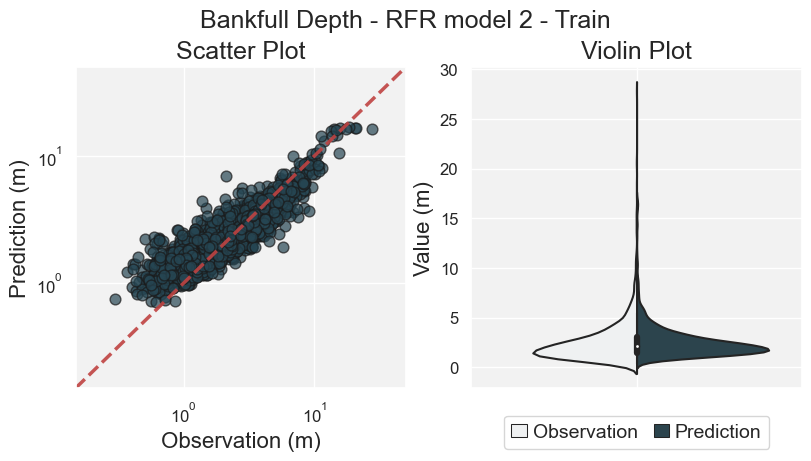

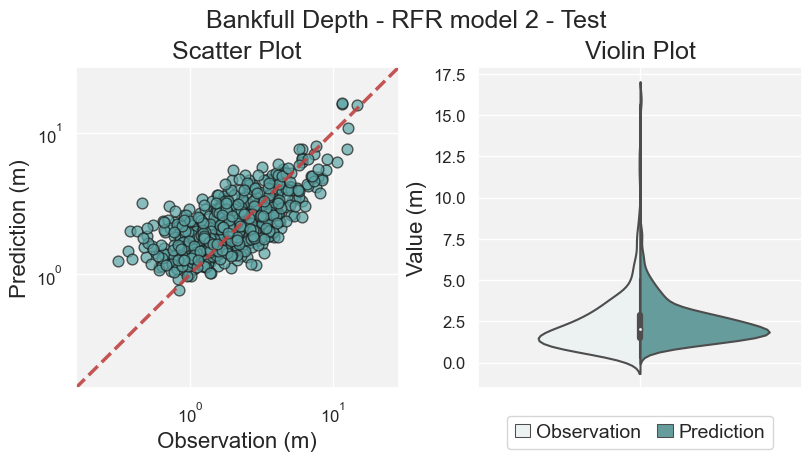

In [43]:
Title = [ 'Bankfull Depth - RFR model 2 - Train', 'Bankfull Depth - RFR model 2 - Test']
fc = ['#264653', '#5DA5A5']
pred_list = [rfr_pred_train, rfr_pred_test]
obs_list = [ y_train, y_test]

for i in range (0,2):
    X = obs_list[i]
    Y = pred_list[i]
    Scatter_Violin_Plots(X, Y, "Observation (m)", "Prediction (m)", "Value (m)", Title[i], fc[i])

## Mean Decrease in Impurity Analysis

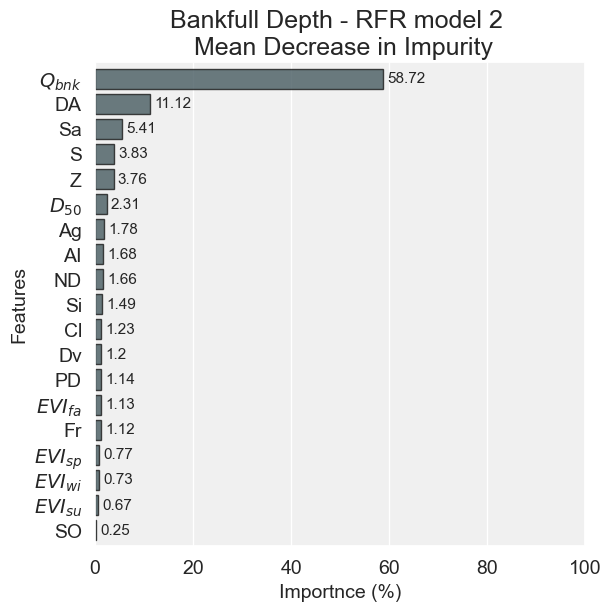

In [44]:
# Rename attributes
Columns=  ['$Q_{bnk}$', 'DA','$EVI_{fa}$', '$EVI_{sp}$', '$EVI_{su}$', '$EVI_{wi}$', 'ND', 'PD', 'SO', '$D_{50}$', 'AI','Dv', 'Fr','Ag', 'Z', 'S', 'Si', 'Cl', 'Sa']

# MDI analysis
result_train = permutation_importance(rf_grid, X_train.values, y_train, n_repeats=10, random_state=42, n_jobs=2)
importances_train = rf_grid.feature_importances_
rfr_importances_MDI_train = pd.Series(importances_train, index=Columns)
rfr_importances_MDI_train.sort_values(ascending=True, inplace=True)
rfr_importances_MDI_train = rfr_importances_MDI_train.multiply(100)
rfr_importances_MDI_train = rfr_importances_MDI_train.round( decimals=2)

# Visualization of results
Hbar(rfr_importances_MDI_train, 'Bankfull Depth - RFR model 2 \n Mean Decrease in Impurity', '#475B61')